# Orthographic similarity classification

In [1]:
# Install dependencies
from polyglot.downloader import downloader
from polyglot.text import Text 
from math import floor, ceil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
# Define a function to calculate the Jaro similarity 

def jaro_distance(s1, s2):
     
    # If the s are equal
    if (s1 == s2):
        return 1.0
 
    # Length of two s
    len1 = len(s1)
    len2 = len(s2)
 
    # Maximum distance upto which matching
    # is allowed
    max_dist = floor(max(len1, len2) / 2) - 1
 
    # Count of matches
    match = 0
 
    # Hash for matches
    hash_s1 = [0] * len(s1)
    hash_s2 = [0] * len(s2)
 
    # Traverse through the first
    for i in range(len1):
 
        # Check if there is any matches
        for j in range(max(0, i - max_dist),
                       min(len2, i + max_dist + 1)):
             
            # If there is a match
            if (s1[i] == s2[j] and hash_s2[j] == 0):
                hash_s1[i] = 1
                hash_s2[j] = 1
                match += 1
                break
 
    # If there is no match
    if (match == 0):
        return 0.0
 
    # Number of transpositions
    t = 0
    point = 0
 
    # Count number of occurrences
    # where two characters match but
    # there is a third matched character
    # in between the indices
    for i in range(len1):
        if (hash_s1[i]):
 
            # Find the next matched character
            # in second
            while (hash_s2[point] == 0):
                point += 1
 
            if (s1[i] != s2[point]):
                t += 1
            point += 1
    t = t//2
 
    # Return the Jaro Similarity
    return (match/ len1 + match / len2 +
            (match - t) / match)/ 3.0

In [3]:
# Preprocess the dataset 

dataset = pd.read_csv('datasets/dataset.csv')

dataset = dataset.drop('Unnamed: 0', axis=1)

dataset['orthographic_sim'] = dataset['false_friends'].replace({0:1,1:1,2:0})

print(dataset.head())

print(dataset.tail())

print(dataset['orthographic_sim'].value_counts())

y_true = dataset['orthographic_sim'].to_list()

   id            pl               uk  false_friends  orthographic_sim
0   1     śniadanie         сніданок              0                 1
1   2  wegetarianin  вегетаріанський              0                 1
2   3         napój            напій              0                 1
3   4          kawa             кава              0                 1
4   5           sok              сік              0                 1
      id           pl          uk  false_friends  orthographic_sim
871  872         pień  обрахувати              2                 0
872  873   podróżować    порушити              2                 0
873  874       czyhać     порвати              2                 0
874  875  dwadzieścia      сапати              2                 0
875  876        słaby      точити              2                 0
1    438
0    438
Name: orthographic_sim, dtype: int64


In [4]:
# Make predictions 
similarities = []

for row in dataset.iterrows():
    pl_word = row[1][1]
    uk_word = row[1][2]

    blob = uk_word
    text = Text(blob, hint_language_code='uk')
    uk_translitareted = str(text.transliterate('en')[0])

    blob2 = pl_word
    text2 = Text(blob2, hint_language_code='pl')
    pl_transliterated = str(text2.transliterate('en')[0])

    similarity_value = round(jaro_distance(uk_translitareted, pl_transliterated),6)

    if similarity_value >= 0.6:
        similarities.append(1)
    else:
        similarities.append(0)

In [5]:
print(classification_report(y_true, similarities))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       438
           1       0.94      0.89      0.92       438

    accuracy                           0.92       876
   macro avg       0.92      0.92      0.92       876
weighted avg       0.92      0.92      0.92       876



In [6]:
confusion_matrix = confusion_matrix(y_true, similarities)

[Text(0, 0.5, 'non-homographs'), Text(0, 1.5, 'homographs')]

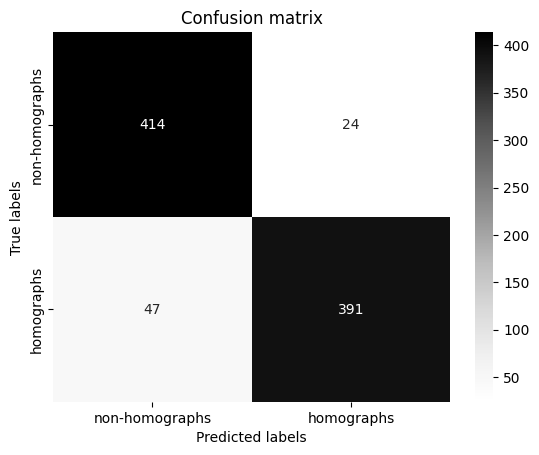

In [7]:
ax = plt.subplot()
sns.heatmap(confusion_matrix,annot=True,fmt='.0f',cmap='Greys')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion matrix') 
ax.xaxis.set_ticklabels(['non-homographs', 'homographs'])
ax.yaxis.set_ticklabels(['non-homographs', 'homographs'])

In [9]:
dataset['predictions'] = similarities

In [10]:
dataset

,id,pl,uk,false_friends,orthographic_sim,predictions
0,1,śniadanie,сніданок,0,1,1
1,2,wegetarianin,вегетаріанський,0,1,1
2,3,napój,напій,0,1,1
3,4,kawa,кава,0,1,1
4,5,sok,сік,0,1,1
...,...,...,...,...,...,...
871,872,pień,обрахувати,2,0,0
872,873,podróżować,порушити,2,0,1
873,874,czyhać,порвати,2,0,0
874,875,dwadzieścia,сапати,2,0,0


In [8]:
dataset.to_csv('datasets/updated_dataset.csv')